# Attention Is All You Need

Notebook for testing my implementations and trying things

## RNNs



### Why important

This was the previous state of the art method for sequence modeling.

The issue is that it maintains a hidden state which is fed forward sequentially. Consequently, this type of network is not parallelizable as each output depends on the previous hidden state.

### Simple character level RNN model

* trained on English to French small dataset


#### Imports + Read Data

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/english_french.csv')
df.head()

,English,French
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !


In [3]:
df.shape, df.map(len).max()

((229803, 2),
 English    290
 French     349
 dtype: int64)

Visualise the character counts

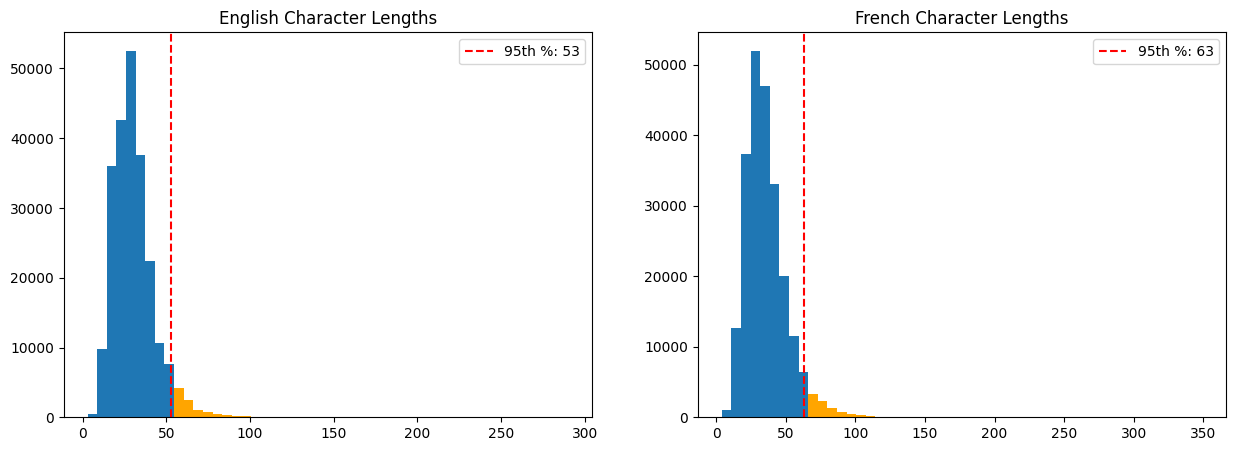

In [4]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

for i, col in enumerate(['English', 'French']):
    # Calculate lengths and 95th percentile
    lengths = df[col].str.len()
    q95 = lengths.quantile(0.95)

    n, bins, patches = ax[i].hist(lengths, bins=50, color='lightgray')
    for bin_left, patch in zip(bins[:-1], patches):
        if bin_left < q95:
            patch.set_facecolor('#1f77b4')  # Standard matplotlib blue
        else:
            patch.set_facecolor('orange')   # Highlight the tail

    # Add a vertical line for reference
    ax[i].axvline(q95, color='red', linestyle='--', label=f'95th %: {q95:.0f}')

    ax[i].set_title(f'{col} Character Lengths')
    ax[i].legend()

plt.show()

**Data Cleaning**

We should filter out the extremely long values to prevent massive padding. I filter out arond the 95th percentile of French texts which also removes outlier texts in the english set.

1) English Characters
* We have soft hyphen and non-breaking space characters, must replace them with "" and " " respectively.
2) French Characters
* We have several other weird characters and odd spaces that I fix

In [5]:
# Weird symbol rows
# df.loc[df['English'].str.contains('[\xa0\xad]',regex=True)]
# df.loc[df['English'].str.contains('₂',regex=True)]

# Clean the text
def clean_data(df):
    clean_df = df.loc[df['French'].str.len() <= 65,: ]

    replacements = {
        '\xa0': ' ',
        '\xad': None,
        '\u2009': ' ',
        '\u200b': '',
        '\u202f': ' ',
    }
    table = str.maketrans(replacements)

    for c in df.columns:
        clean_df[c] = df[c].str.translate(table)

    return clean_df

df = clean_data(df)


/var/folders/cl/zn1hyrv504zg3bb_xm552h5m0000gn/T/ipykernel_23192/1669458672.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[c] = df[c].str.translate(table)
/var/folders/cl/zn1hyrv504zg3bb_xm552h5m0000gn/T/ipykernel_23192/1669458672.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[c] = df[c].str.translate(table)


**Encode characters**

Special padding tokens, start of sequence and end of sequence tokens to mark key points in translating

In [6]:
english_chars = sorted(set(''.join(df['English'].astype(str))))
french_chars = sorted(list(set(''.join(df['French']))))
special_tokens = ['<PAD>', '<SOS>', '<EOS>']

# Integer to string encodings
fitos = {idx + len(special_tokens):char for idx, char in enumerate(french_chars)}
eitos = {idx + len(special_tokens):char for idx, char in enumerate(english_chars)}

for i, token in enumerate(special_tokens):
    fitos[i] = token
    eitos[i] = token

# String to integer encodings
fstoi ={c:i for i,c in fitos.items()}
estoi ={c:i for i,c in eitos.items()}
estoi

{' ': 3,
 '!': 4,
 '"': 5,
 '$': 6,
 '%': 7,
 '&': 8,
 "'": 9,
 ',': 10,
 '-': 11,
 '.': 12,
 '/': 13,
 '0': 14,
 '1': 15,
 '2': 16,
 '3': 17,
 '4': 18,
 '5': 19,
 '6': 20,
 '7': 21,
 '8': 22,
 '9': 23,
 ':': 24,
 ';': 25,
 '?': 26,
 'A': 27,
 'B': 28,
 'C': 29,
 'D': 30,
 'E': 31,
 'F': 32,
 'G': 33,
 'H': 34,
 'I': 35,
 'J': 36,
 'K': 37,
 'L': 38,
 'M': 39,
 'N': 40,
 'O': 41,
 'P': 42,
 'Q': 43,
 'R': 44,
 'S': 45,
 'T': 46,
 'U': 47,
 'V': 48,
 'W': 49,
 'X': 50,
 'Y': 51,
 'Z': 52,
 'a': 53,
 'b': 54,
 'c': 55,
 'd': 56,
 'e': 57,
 'f': 58,
 'g': 59,
 'h': 60,
 'i': 61,
 'j': 62,
 'k': 63,
 'l': 64,
 'm': 65,
 'n': 66,
 'o': 67,
 'p': 68,
 'q': 69,
 'r': 70,
 's': 71,
 't': 72,
 'u': 73,
 'v': 74,
 'w': 75,
 'x': 76,
 'y': 77,
 'z': 78,
 '°': 79,
 'é': 80,
 'ï': 81,
 'ú': 82,
 '–': 83,
 '‘': 84,
 '’': 85,
 '₂': 86,
 '€': 87,
 '<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2}

Define encoding/decoding functions:

1) English input to encoder-> add EOS and pad to max_len_english so all inputs are the same
2) French input to decoder -> shift right and prepend with SOS, pad to max_len_french
3) French target -> add EOS and pad to max_len_french

In [7]:
# +1 because we add a eos/sos char to the longest components
MAX_LEN_ENGLISH = int(df['English'].map(len).max()) + 1
MAX_LEN_FRENCH = int(df['French'].map(len).max()) + 1

def encode_text(text:str,add_eos:bool,add_sos:bool, english = True):
    """Take a text string and encode to integers + add necessary special characters to it"""

    # Get raw indices from necessary dicts
    indices = [estoi[c] for c in text] if english else [fstoi[c] for c in text]


    # Add the sequence boundaries as necessary
    if add_eos:
        indices.append(estoi['<EOS>'])

    elif add_sos:
        indices.insert(0,estoi['<SOS>'])


    #Pad to necessary length
    num_padding = MAX_LEN_ENGLISH - len(indices) if english else MAX_LEN_FRENCH - len(indices)

    indices.extend([estoi['<PAD>']]* num_padding)

    return indices

def decode_text(indices:list[int],english = False):
    if english:
        return ''.join([eitos[i] for i in indices])
    else:
        return ''.join([fitos[i] for i in indices])


# Try encoding
# english_input = encode_text(df['English'][0],add_eos=True,add_sos=False, english = True)
# french_input = encode_text(df['French'][0],add_eos=False,add_sos=True, english = False)
# french_target = encode_text(df['French'][0],add_eos=True,add_sos=False, english = False)
# decode_text(french_input)
# decode_text(french_target)
# decode_text(english_input, english = True)

In [8]:
print(MAX_LEN_FRENCH)

66


Create new pd columns

In [9]:
df['x_en'] = df['English'].apply(lambda x: encode_text(x,add_eos=True,add_sos=False, english = True))
df['x_fr'] = df['French'].apply(lambda x: encode_text(x,add_eos=False,add_sos=True, english = False))
df['y_fr'] = df['French'].apply(lambda x: encode_text(x,add_eos=True,add_sos=False, english = False))
df.head()

,English,French,x_en,x_fr,y_fr
0,Go.,Va !,"[33, 67, 12, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 51, 56, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[51, 56, 3, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,Go.,Marche.,"[33, 67, 12, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 42, 56, 73, 58, 63, 60, 15, 0, 0, 0, 0, 0,...","[42, 56, 73, 58, 63, 60, 15, 2, 0, 0, 0, 0, 0,..."
2,Go.,En route !,"[33, 67, 12, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 34, 69, 3, 73, 70, 76, 75, 60, 3, 4, 0, 0,...","[34, 69, 3, 73, 70, 76, 75, 60, 3, 4, 2, 0, 0,..."
3,Go.,Bouge !,"[33, 67, 12, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 31, 70, 76, 62, 60, 3, 4, 0, 0, 0, 0, 0, 0...","[31, 70, 76, 62, 60, 3, 4, 2, 0, 0, 0, 0, 0, 0..."
4,Hi.,Salut !,"[34, 61, 12, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 48, 56, 67, 76, 75, 3, 4, 0, 0, 0, 0, 0, 0...","[48, 56, 67, 76, 75, 3, 4, 2, 0, 0, 0, 0, 0, 0..."


Create the Training/Val/Test split

In [10]:
# Shuffle and split
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

tidx = int(len(df)*0.8)
vidx = int(len(df)*0.9)

train_df = df.iloc[:tidx,:] # 80%
val_df = df.iloc[tidx:vidx,:] # 10%
test_df = df.iloc[vidx:,:] # 10%


In [11]:
# Tensors
Xtr_en, Xtr_fr, Ytr = torch.tensor(train_df['x_en'].tolist()), torch.tensor(train_df['x_fr'].tolist()), torch.tensor(train_df['y_fr'].tolist())
Xev_en, Xev_fr, Yev = torch.tensor(val_df['x_en'].tolist()), torch.tensor(val_df['x_fr'].tolist()), torch.tensor(val_df['y_fr'].tolist())
Xte_en, Xte_fr, Yte = torch.tensor(test_df['x_en'].tolist()), torch.tensor(test_df['x_fr'].tolist()), torch.tensor(test_df['y_fr'].tolist())

# Check encodings.
# for n in range(5):
#     print(decode_text(Xtr_en[n].tolist(),english=True),decode_text(Xtr_fr[n].tolist()),decode_text(Ytr[n].tolist()),sep='\n',end='\n\n')


Xtr_en.shape, Xev_en.shape, Xte_en.shape

(torch.Size([176160, 87]), torch.Size([22020, 87]), torch.Size([22021, 87]))

We have 87 dimensional input vectors to the encoder

#### Model



**Encoder**

Takes in 87 dim input vector, applies embedding so we have B x 87 x C dimensional tensor per batch where 87 is the time dimension and C is the channels/embedding

Pass through an input layer 32x 87 x 64

hx = torch.zeros(32,256)
for t in [:,0,:] -> 32 x 64 embeddings for the first character in each example:
 tanh(i2h(t) + h2h(hx)) -> 32 x 256 hidden vectors for each batch.






In [12]:
VOCAB_SIZE_EN = len(english_chars) + len(special_tokens)
VOCAB_SIZE_FR = len(french_chars) + len(special_tokens)
EMBEDDING_DIM = 64
HIDDEN_DIM = 256

class RNNEncoder(torch.nn.Module):
    """RNN Encoder class. Takes in an English input and outputs a hidden state for the decoder."""
    def __init__(self, vocab_size:int, embedding_dim:int, hidden_dim:int,):
        super().__init__()
        self.hidden_dim = hidden_dim
        # Embedding layer for the tokens
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.i2h = torch.nn.Linear(embedding_dim, hidden_dim)
        self.h2h = torch.nn.Linear(hidden_dim, hidden_dim)
        self.act = torch.nn.Tanh()


    def forward(self, Xen:torch.Tensor):
        Xen = self.embedding(Xen)
        B, T, C = Xen.shape
        # Initialise the hidden vector and output vector
        hx = torch.zeros(B, self.hidden_dim)
        outputs = []
        for t in range(T):
            # 32 x 1 x 64 -> 32 x 1 x 256 , + 32 x 256 = hidden vectors across the batch
            pre_act = self.i2h(Xen[:, t, :]) + self.h2h(hx)
            hx = self.act(pre_act)
            outputs.append(hx)

        # Combine the 32 x 256 tensors to have the hidden vectors across time
        rnn_output = torch.stack(outputs, dim = 1)

        # Return the final hidden states, 32x256 , output is irrelevant for this model.
        return hx

class RNNDecoder(torch.nn.Module):
    def __init__(self, vocab_size:int, embedding_dim:int, hidden_dim:int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.i2h = torch.nn.Linear(embedding_dim, hidden_dim)
        self.h2h = torch.nn.Linear(hidden_dim, hidden_dim)
        self.act = torch.nn.Tanh()
        self.out = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, Xen:torch.Tensor, hx:torch.Tensor):
        Xen = self.embedding(Xen)
        B, T, C = Xen.shape
        # In the decoder, the outputs store the logits
        # Initially the decoder has a SOS char plus the meaning encoded in the encoder vectors across the batch
        outputs = []
        for t in range(T):
            pre_act = self.i2h(Xen[:, t, :]) + self.h2h(hx)
            hx = self.act(pre_act)

            logits_example = self.out(hx)

            outputs.append(logits_example)

        # Now we have the logits across the batch 32 x 65 x 256
        logits = torch.stack(outputs, dim = 1)

        return logits, hx


encoder = RNNEncoder(VOCAB_SIZE_EN, EMBEDDING_DIM, HIDDEN_DIM)
decoder = RNNDecoder(VOCAB_SIZE_FR, EMBEDDING_DIM, HIDDEN_DIM)


**Pass a batch through the encoder, through the decoder, then compute loss**

In [13]:
Xbe,Xbf,Yb = Xtr_en[:32], Xtr_fr[:32], Ytr[:32]

# 32x 87 batch -> Encoder -> Decoder with corresponding 32x66 french char sequences and 32x256 hidden state containing the meaning of the english -> logits
h = encoder(Xbe)
logitsb, _ = decoder(Xbf,h)
# we now have 32x66x110 logits.


# Compute loss over the batch.
# Arrange the examples in a (N,C,..) format as per the F.cross_entropy spec
logitsb= logitsb.permute(0,2,1)
loss = F.cross_entropy(logitsb, Yb)
loss

tensor(4.6161, grad_fn=<NllLoss2DBackward0>)

#### Training Loop

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Encoder params: {count_parameters(encoder)}")
print(f"Decoder params: {count_parameters(decoder)}")
print(f"Total params:   {count_parameters(encoder) + count_parameters(decoder)}")

Encoder params: 88064
Decoder params: 117742
Total params:   205806


In [15]:
MAX_STEPS = 10000

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=1e-3
)

for step in range(MAX_STEPS):
    ix_b = torch.randint(0,Xtr_en.shape[0], size = (64,))
    Xbe,Xbf,Yb = Xtr_en[ix_b], Xtr_fr[ix_b], Ytr[ix_b]
    h = encoder(Xbe)
    logitsb, _ = decoder(Xbf,h)
    logitsb= logitsb.permute(0,2,1)
    loss = F.cross_entropy(logitsb, Yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Step {step}: {loss.item()}")


Step 0: 4.627191543579102
Step 1: 4.048192977905273
Step 2: 3.537266492843628
Step 3: 3.0725362300872803
Step 4: 2.830479383468628
Step 5: 2.4916205406188965
Step 6: 2.386229991912842
Step 7: 2.222365379333496
Step 8: 2.3109171390533447
Step 9: 2.36897349357605
Step 10: 2.0925276279449463
Step 11: 2.1243627071380615
Step 12: 2.1620233058929443
Step 13: 1.9057412147521973
Step 14: 1.981152892112732
Step 15: 1.8950355052947998
Step 16: 1.7038049697875977
Step 17: 1.6732693910598755
Step 18: 1.7337874174118042
Step 19: 1.5634160041809082
Step 20: 1.5906637907028198
Step 21: 1.4801775217056274
Step 22: 1.4649401903152466
Step 23: 1.469246506690979
Step 24: 1.5291147232055664
Step 25: 1.5733695030212402
Step 26: 1.5078563690185547
Step 27: 1.4302430152893066
Step 28: 1.4695117473602295
Step 29: 1.4772571325302124
Step 30: 1.4518122673034668
Step 31: 1.4024475812911987
Step 32: 1.467482328414917
Step 33: 1.4291540384292603
Step 34: 1.3988953828811646
Step 35: 1.416190505027771
Step 36: 1.341

In [20]:
def calculate_loss(dataset:str):
    if dataset == 'train':
        X_en = Xtr_en[:1000]
        X_fr = Xtr_fr[:1000]
        Y = Ytr[:1000]
    elif dataset == 'val':
        X_en = Xev_en[:1000]
        X_fr = Xev_fr[:1000]
        Y = Yev[:1000]
    else:
        X_en = Xte_en[:1000]
        X_fr = Xte_fr[:1000]
        Y = Yte[:1000]

    h = encoder(X_en)
    logitsb, _ = decoder(X_fr,h)
    logitsb= logitsb.permute(0,2,1)
    loss = F.cross_entropy(logitsb, Y)
    return loss




In [21]:
print(calculate_loss('train'))
print(calculate_loss('val'))
print(calculate_loss('test'))

tensor(0.5700, grad_fn=<NllLoss2DBackward0>)
tensor(0.5820, grad_fn=<NllLoss2DBackward0>)
tensor(0.5719, grad_fn=<NllLoss2DBackward0>)


### Sample from machine

In [22]:
eng_sentence = Xte_en[0].view(1,-1)
h = encoder(eng_sentence)

curr_token = torch.tensor([[1]])
print(curr_token)

decoded_indices = []

max_generation_len = 50

for i in range(max_generation_len):
    logits, h = decoder(curr_token, h)
    probs = F.softmax(logits.squeeze(), dim=0)

    next_token_idx = torch.argmax(probs).item()

    if next_token_idx == 0:
        break

    decoded_indices.append(next_token_idx)

    curr_token = torch.tensor([[next_token_idx]])

print(f"Indices: {decoded_indices}")


tensor([[1]])
Indices: [39, 60, 3, 69, 60, 3, 74, 76, 64, 74, 3, 71, 56, 74, 3, 58, 70, 69, 75, 73, 60, 3, 67, 60, 3, 58, 70, 69, 75, 73, 60, 3, 67, 60, 3, 68, 70, 68, 60, 69, 75, 15, 2, 15, 2]


In [24]:
print(decode_text(eng_sentence.tolist()[0],english = True),
# decode_text(fr_sentence.tolist()),
decode_text(decoded_indices))

Tom said it wasn't necessary.<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD> Je ne suis pas contre le contre le moment.<EOS>.<EOS>


Status: Model seems to understand french grammar and language, clearly not retaining enough of the meaning, maybe gradient bug

Explore GRU/LSTM